In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from typing_extensions import Annotated
from langgraph.graph import add_messages
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-5-mini')

class MyState(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: MyState) -> MyState:
    ai_response = llm.invoke(state["messages"])
    return {"messages": [ai_response]}

graph_builder = StateGraph(MyState)
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

resp = graph.stream({"messages": [("user", "What is Clawdbot?")]})

for chunk in resp:
    for value in chunk.values():
        print("AI: ", value["messages"][-1].content)

AI:  I’m not sure which “Clawdbot” you mean — there are a few different things that name could refer to. Where did you see it (a website, Discord server, robotics club, game, paper, etc.)? A quick rundown of likely possibilities — tell me which one matches and I’ll give details:

- Discord bot: a community bot named “Clawdbot” might provide moderation, music, custom commands, or fun features. If this is it I can explain how to invite/configure it, list common commands, or help set up a similar bot.

- Robotics/kit robot: some robotics teams and kits use the name “Clawbot”/“Clawdbot” for a small robot with a claw/grabber (used in VEX, FIRST, classroom projects). If that’s what you mean I can describe typical hardware, control code examples, or building tips.

- Claw/crane-game bot: could be a bot that automates playing a claw-machine game (web or arcade). I can explain how such bots work and legal/ethical issues.

- Other software/service: it might be a niche project (trading bot, Twitc

In [3]:
import os
from getpass import getpass
from langchain_tavily import TavilySearch

os.environ["TAVILY_API_KEY"] = getpass("Enter your Tavily API Key: ")

tools = [TavilySearch(max_results=3)]
tools[0].invoke("What is Clawdbot?")

{'query': 'What is Clawdbot?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.jotform.com/ai/agents/what-is-clawdbot/',
   'title': 'Clawdbot explained: What it is and how to try this AI assistant - Jotform',
   'content': 'Clawdbot is an open-source AI assistant for WhatsApp, Telegram, and Discord that automates tasks, manages emails and calendars, and executes',
   'score': 0.9501204,
   'raw_content': None},
  {'url': 'https://wavespeed.ai/blog/posts/what-is-clawdbot-personal-ai-assistant',
   'title': 'What Is Clawdbot? The Personal AI Assistant Everyone Is Talking ...',
   'content': 'Clawdbot is an open-source personal AI assistant that operates on your own devices and delivers responses through messaging platforms like',
   'score': 0.9385817,
   'raw_content': None},
  {'url': 'https://medium.com/data-science-in-your-pocket/what-is-clawdbot-the-viral-ai-assistant-b432d275de66',
   'title': 'What is ClawdBot ? The viral AI Assista

In [4]:
llm_with_tools = llm.bind_tools(tools)

def chatbot_with_tools(state: MyState) -> MyState:
    ai_response = llm_with_tools.invoke(state["messages"])
    return {"messages": [ai_response]}

new_graph_builder = StateGraph(MyState)
new_graph_builder.add_node("chatbot", chatbot_with_tools)


In [6]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: MyState) -> MyState:
        messages = inputs.get("messages", [])
        if messages:
            last_message = messages[-1]
        else:
            raise ValueError("No messages found in the input state.")
        
        outputs = []

        for tool_call in last_message.tool_calls:
            tool_response = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                ToolMessage(
                    content = json.dumps(tool_response),
                    name = tool_call["name"],
                    tool_call_id = tool_call["id"]
                )
            )

        return {"messages": outputs}

In [7]:
tool_node = BasicToolNode(tools)
new_graph_builder.add_node("tool_node", tool_node)

In [8]:
def route_tools(state: MyState) -> str:
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tool_node"
    else:
        return END

In [9]:
new_graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {
        "tool_node": "tool_node",
        END: END
    }
)

In [10]:
new_graph_builder.add_edge("tool_node", "chatbot")
new_graph_builder.add_edge(START, "chatbot")

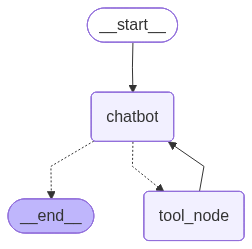

In [11]:
new_graph = new_graph_builder.compile()
from IPython.display import Image, display

try:
    display(Image(new_graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [ ]:
resp = new_graph.stream({"messages": [("user", "What is Clawdbot?")]})

from langchain_core.messages import BaseMessage

for chunk in resp:
    for value in chunk.values():
        if isinstance(value["messages"][-1], ToolMessage):
            print("\nTool Response: ", value["messages"][-1].content)
        elif isinstance(value["messages"][-1], BaseMessage):
            print("\nAI: ", value["messages"][-1].content)


AI:  

Tool Response:  {"query": "Clawdbot what is Clawdbot", "response_time": 0.73, "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.jotform.com/ai/agents/what-is-clawdbot/", "title": "Clawdbot explained: What it is and how to try this AI assistant", "content": "Clawdbot is an open-source AI assistant for WhatsApp, Telegram, and Discord that automates tasks, manages emails and calendars, and executes", "score": 0.9291904, "raw_content": null}, {"url": "https://wavespeed.ai/blog/posts/what-is-clawdbot-personal-ai-assistant", "title": "What Is Clawdbot? The Personal AI Assistant Everyone Is ...", "content": "Clawdbot is an open-source personal AI assistant that operates on your own devices and delivers responses through messaging platforms like", "score": 0.91563576, "raw_content": null}, {"url": "https://www.reddit.com/r/ClaudeCode/comments/1qmrkdu/clawdbot_the_5month_ai_assistant_that_actually/", "title": "the $5/month AI assistant that actu